In [1]:
import numpy as np
import tensorflow as tf
print(tf.__version__)
import tensorflow_datasets as tfds
from tqdm import tqdm

from PIL import Image

2.8.0


In [2]:
import time
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import os
import random
from sklearn.datasets import make_moons

In [41]:
a = np.random.normal(0, 0.6, 40000)

In [42]:
a = a.reshape(4000, 10)

# Creating the dataset

In [10]:
X, Y = make_moons(n_samples=5000, noise=0.05)
X = X.astype('float32')

In [11]:
def plot_data(ax, X, Y, color = 'gist_gray'):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap=color)

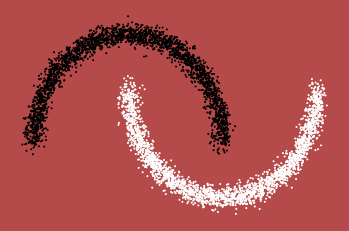

In [12]:
n_samples = X.shape[0]
fig, ax = plt.subplots(1, 1, facecolor='#b54a4a')
plot_data(ax, X, Y)
plt.show()

In [13]:
X.shape

(5000, 2)

In [14]:
from sklearn.model_selection import train_test_split as split

In [15]:
X_train, X_test, Y_train, Y_test = split(X, Y, train_size=0.8, random_state=312)

In [16]:
XY_train = np.c_[X_train, Y_train].astype('float32',casting='same_kind')

# Encoder and Decoder


In [17]:
from keras.layers.advanced_activations import LeakyReLU

In [18]:
models = {}

In [20]:
LATENT_DIM = 10
OUTPUT_DIM = 256

ll = tf.keras.layers

# encoder
encoder_base = tf.keras.Sequential([
    ll.Input(shape=(2,)), #(2,) 3 for features
    ll.Dense(OUTPUT_DIM, activation='relu'),
    ll.BatchNormalization(),
    ll.Dropout(0.3),
    ll.Dense(OUTPUT_DIM / 2, activation='relu'),
    ll.BatchNormalization(),
    ll.Dropout(0.3),
    ll.Dense(OUTPUT_DIM / 4, activation='relu'),
    ll.BatchNormalization(),
    ll.Dropout(0.3)])

latent_mu = ll.Dense(LATENT_DIM, activation=None)(encoder_base.output)
latent_log_sigma = ll.Dense(LATENT_DIM, activation=None)(encoder_base.output)

encoder = tf.keras.Model(inputs=encoder_base.inputs, outputs=[latent_mu, latent_log_sigma])

# decoder
decoder = tf.keras.Sequential([
    ll.Input(shape=(LATENT_DIM, )), # no +1 if no features
    ll.Dense(OUTPUT_DIM / 4),
    LeakyReLU(),
    ll.BatchNormalization(),
    ll.Dropout(0.3),
    ll.Dense(OUTPUT_DIM / 2),
    LeakyReLU(),
    ll.BatchNormalization(),
    ll.Dropout(0.3),
    ll.Dense(OUTPUT_DIM),
    LeakyReLU(),
    ll.BatchNormalization(),
    ll.Dropout(0.3),
    ll.Dense(2)]) # 2, 3 for labeling
# provided a condition, decoder generates some date

In [21]:
decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                704       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64)                0         
                                                                 
 batch_normalization_9 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 128)               8320      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128)               0         
                                                      

In [22]:
def random_generator(mu, log_sigma):
  return decoder(tf.random.normal(shape=mu.shape) * tf.exp(log_sigma) + mu) # concatinate the vector of normal values with the labels from the original data

# @tf.function decorator below compiles the function
# it decorates into a static graph. This improves the performance
# but there are some pitfalls one should be aware of when using it,
# check out https://www.tensorflow.org/guide/function
# for more details
@tf.function
def forward(batch):
  real = batch

  mu, log_sigma = encoder(real) #XY labelled
  fake = random_generator(mu, log_sigma)

  loss_mse = tf.reduce_sum((real - fake)**2)
  loss_KL = tf.reduce_sum(-log_sigma + 0.5 * (mu**2 + tf.exp(2 * log_sigma) - 1), axis=1)
  return tf.reduce_mean(loss_mse + 0.2 * loss_KL) # 0.2 - beta-VAE, beta = 0.2

opt_g = tf.optimizers.Adam()

@tf.function
def gen_step(batch):
  with tf.GradientTape() as t:
    g_loss = forward(batch)
  grads = t.gradient(g_loss, encoder.trainable_variables + decoder.trainable_variables)
  opt_g.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))
  return g_loss


In [24]:
from IPython.display import clear_output
from tqdm import trange

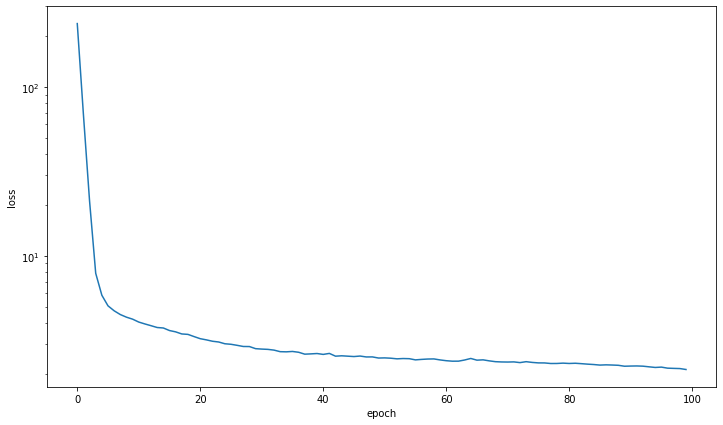

Done with epoch # 99


In [25]:
BATCH_SIZE = 256

N_EPOCHS = 100

losses = []
for i_ep in range(N_EPOCHS):
  shuffle_ids = np.random.choice(len(X_train), len(X_train), replace=False) # len(XY_train not sufficient every time)
  epoch_loss = 0
  for i_img in trange(0, len(X_train), BATCH_SIZE):
    batch = X_train[shuffle_ids][i_img:i_img + BATCH_SIZE]
    epoch_loss += gen_step(batch).numpy() * len(batch)

  epoch_loss /= len(X_train)
  losses.append(epoch_loss)

  opt_g.learning_rate.assign(opt_g.learning_rate * 0.99)

  clear_output(wait=True)
  plt.figure(figsize=(12, 7))
  plt.plot(losses)
  plt.yscale('log')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()
  print("Done with epoch #", i_ep)

In [26]:
import seaborn as sns

In [27]:
codes = encoder.predict(X_train) # codes[0] = mean (data itself), codes[1] = standard deviation
reco = decoder.predict(codes[0])

aaa

In [ ]:
codre = np.asarray(codes)

aaa

In [38]:
len(codes)

2

In [40]:
np.array(codes[0]).reshape(40000,).std()

0.61712813

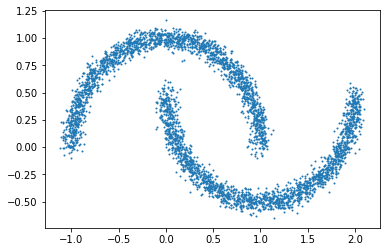

In [28]:
fig, ax = plt.subplots(1, 1, facecolor='white')
ax.scatter(X_train[:, 0], X_train[:, 1], s=1)
plt.show()

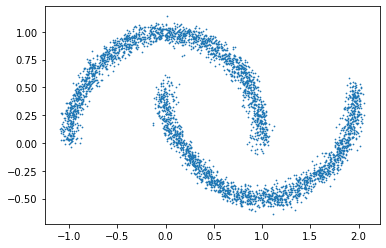

In [33]:
fig, ax = plt.subplots(1, 1, facecolor='white')
ax.scatter(reco[:, 0], reco[:, 1], s=0.5)#, c=reco[:, 2], cmap='Paired')
plt.show()

In [45]:
codes_1 = encoder.predict(X_test)

In [46]:
reco_1 = decoder.predict(codes_1[0])

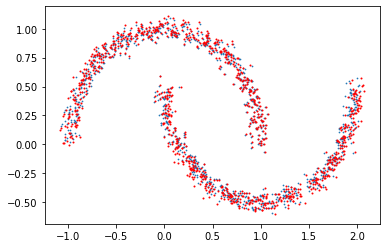

In [49]:
fig, ax = plt.subplots(1, 1, facecolor='white')
ax.scatter(reco_1[:, 0], reco_1[:, 1], s=0.5)#, c=reco[:, 2], cmap='Paired')
ax.scatter(X_test[:, 0], X_test[:, 1], s=1, color='red')
plt.show()

In [ ]:
# generate labelled data
# slicing the time axis within the batch at positions (0,1) to be worked on in the RNNV

# trying CVAE on the 2dim --> concerning double-correlations within one batch

# running through convolutions is slower ususally than fully-connected (encoder ought not be used in production - slow asp )

In [ ]:
XY_test = np.c_[X_test, Y_test].astype('float32', casting='same_kind')

In [ ]:
codes_test = encoder.predict(XY_test)
reco_test = decoder.predict(codes_test[0])

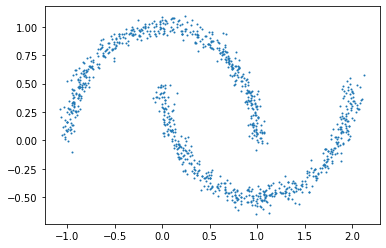

In [ ]:
fig, ax = plt.subplots(1, 1, facecolor='white')
ax.scatter(X_test[:, 0], X_test[:, 1], s=1)
plt.show()

TypeError: ignored

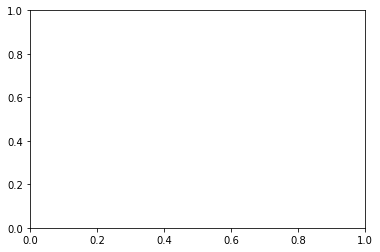

In [ ]:
fig, ax = plt.subplots(1, 1, facecolor='white')
ax.scatter(reco_test[:, 0], reco_test[:, 1], s=1, c=reco_test[:, 2], cmap='Paired')
plt.show()

In [ ]:
print((reco_test[:,0] == reco[:,0]))

False


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.
